In [1]:
import numpy as np
import pandas as pd
import networkx as nx 
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import pickle
import json
from pathlib import Path
import time
from tqdm import tqdm
from joblib import Parallel, delayed, dump, load
import random
import _utilities

import torch
import torch.nn as nn
import torch.nn.functional as F
import mlflow
from sklearn.preprocessing import StandardScaler

In [2]:
with open( './cells_of_interest.json', 'r') as f:
   cells_of_interest = json.load(f)

In [3]:
len(cells_of_interest)

334

In [4]:
with open('./cells_info.pickle', 'rb') as f:
    cells_info = pickle.load(f)
cells_info['ABal']

{'mother_cell': 'ABa',
 'daughter_cells': ['ABala', 'ABalp'],
 'trajectory_raw': {'WT-EMB01':     frame      x      y   z
  0      14  17.16  23.98  19
  1      15  16.72  26.18  18
  2      16  16.94  27.50  16
  3      17  16.50  28.82  16
  4      18  14.74  28.82  18
  5      19  14.52  28.38  18
  6      20  14.74  27.72  19
  7      21  14.30  28.60  19
  8      22  13.86  28.38  18
  9      23  13.42  28.38  17
  10     24  13.20  28.82  16
  11     25  13.86  28.16  15
  12     26  14.52  26.62  16,
  'WT-EMB02':     frame      x      y   z
  0      25  16.94  23.54  13
  1      26  17.16  25.96  15
  2      27  17.38  26.62  16
  3      28  16.28  26.62  15
  4      29  14.52  26.40  14
  5      30  13.64  25.96  13
  6      31  14.30  25.30  13
  7      32  13.86  27.94  14
  8      33  14.08  26.84  15
  9      34  13.86  26.40  16
  10     35  14.08  25.96  15
  11     36  15.18  24.64  17
  12     37  16.28  23.98  16,
  'WT-EMB03':     frame      x      y   z
  0      12 

In [5]:
with open('./embryo_cells_info.pickle', 'rb') as f:
    embryo_cells_info = pickle.load(f)
embryo_cells_info['WT-EMB12']['ABal']

{'trajectory_processed':     frame          x         y         z
 0       1 -17.149992  0.614791  1.585662
 1       2 -16.269992  2.154791  1.585662
 2       3 -16.709992  4.354791  1.585662
 3       4 -18.249992  4.574791  3.585662
 4       5 -19.789992  3.474791  4.585662
 5       6 -20.889992  2.374791  3.585662
 6       7 -21.329992  4.354791  2.585662
 7       8 -21.109992  3.254791  2.585662
 8       9 -21.109992  3.034791  2.585662
 9      10 -20.889992  3.474791  0.585662
 10     11 -20.229992  2.814791 -1.414338,
 'trajectory_processed_txyz':      time          x         y         z
 0    1.25 -17.149992  0.614791  1.585662
 1    2.50 -16.269992  2.154791  1.585662
 2    3.75 -16.709992  4.354791  1.585662
 3    5.00 -18.249992  4.574791  3.585662
 4    6.25 -19.789992  3.474791  4.585662
 5    7.50 -20.889992  2.374791  3.585662
 6    8.75 -21.329992  4.354791  2.585662
 7   10.00 -21.109992  3.254791  2.585662
 8   11.25 -21.109992  3.034791  2.585662
 9   12.50 -20.889992 

In [6]:
embryos_for_test = ['WT-EMB05','WT-EMB12','WT-EMB19','WT-EMB26']
embryos_for_cross_validation = [embryo_name for embryo_name in embryo_cells_info if embryo_name not in embryos_for_test]

In [7]:
print(embryos_for_cross_validation)

['WT-EMB01', 'WT-EMB02', 'WT-EMB03', 'WT-EMB04', 'WT-EMB06', 'WT-EMB07', 'WT-EMB08', 'WT-EMB09', 'WT-EMB10', 'WT-EMB11', 'WT-EMB13', 'WT-EMB14', 'WT-EMB15', 'WT-EMB16', 'WT-EMB17', 'WT-EMB18', 'WT-EMB20', 'WT-EMB21', 'WT-EMB22', 'WT-EMB23', 'WT-EMB24', 'WT-EMB25', 'WT-EMB27', 'WT-EMB28']


In [8]:
len(embryos_for_cross_validation)

24

# RNN model

In [9]:
class RNN(nn.Module):
    def __init__(self, output_size = 334):
        super().__init__()
        self.flat = nn.Flatten() # flatten features
        self.unflat = nn.Unflatten(1, (50,3))  # trajectory input of shape (N, Lx3) to (N, L, 3), where N is batch_size, L=50 is seq_length
        # Hidden layer
        self.rnn = nn.GRU(3, 3, num_layers=2, batch_first=True) # (x,y,z)
        # final Output layer
        self.fc_out = nn.LazyLinear(output_size) # output layer

    def forward(self, x, x_extra = None):
        """_summary_

        Parameters
        ----------
        x : tensor
            trajectory features
        x_extra : tensor
            extra features, like start_frame, lifespan, division orientations, by default None

        Returns
        -------
        tensor
            forward pass of (x, x_extra)
        """     
        # trajectory branch
        # convert x from (N, Lx3) to (N, L, 3), where L should be 50
        out = self.unflat(x)
        out, _ = self.rnn(out) # out is of shape (N, L, H_out), where N is batch_size, L is seq_length, H_out is hidden feature size. In our case, out is of shape (N, 50, 3)  
        out = self.flat(out) # to shape (N, 50*3)
        # no extra features as input, only trajectory
        if x_extra is None: 
            out = self.fc_out(out)
        else:
            x_extra = self.flat(x_extra)
            out = torch.cat((out, x_extra), dim = 1)
            out = self.fc_out(out)
        return out

In [10]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

random_seed = 0
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if device=='cuda':
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark = False

# Batch_size
batch_size = 128

# Prepare data

# train and val data
i = 0
embryos_val = embryos_for_cross_validation[4*i:4*i+4]
embryos_train = [embryo_name for embryo_name in embryos_for_cross_validation if embryo_name not in embryos_val]
X_train, _, y_train = _utilities.prepare_data_for_model(embryo_cells_info, embryos_train, use_frame = True, lifespan_frame_longest = 50, preserve_time_dimension = False, flatten = True)
X_val, _, y_val = _utilities.prepare_data_for_model(embryo_cells_info, embryos_val, use_frame = True, lifespan_frame_longest = 50, preserve_time_dimension = False, flatten = True)
# test data
X_test, _, y_test = _utilities.prepare_data_for_model(embryo_cells_info, embryos_for_test, use_frame = True, lifespan_frame_longest = 50, preserve_time_dimension = False, flatten = True)

# feature normalization
scaler = StandardScaler()
scaler.fit(np.array(X_train))
X_train = scaler.transform(np.array(X_train))
# standardize X_val and X_test
X_val = scaler.transform(np.array(X_val))
X_test = scaler.transform(np.array(X_test))


# Dataset
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.array(X_train, dtype=np.float32)), torch.from_numpy(np.array(y_train)).type(torch.LongTensor))
val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.array(X_val, dtype=np.float32)), torch.from_numpy(np.array(y_val)).type(torch.LongTensor))
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.array(X_test, dtype =np.float32)), torch.from_numpy(np.array(y_test)).type(torch.LongTensor))
# Dataloader 
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### Train and Validate model
model = RNN(output_size=len(cells_of_interest)).to(device)
lr = 0.001
weight_decay=0.2 # L2 regularization
optimizer = torch.optim.AdamW(model.parameters(), lr=lr,weight_decay=weight_decay)

num_epochs = 2500
log_interval = 100
test_interval = 50
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []
test_accuracy = []

start_time = time.time()
# Training
for epoch in range(num_epochs):
    acc_train, loss_train = _utilities.train_rnn(model, train_dl, optimizer, device)
    acc_valid, loss_valid = _utilities.evaluate_rnn(model, train_dl, optimizer, device)
    train_loss.append(loss_train)
    train_accuracy.append(acc_train)
    val_loss.append(loss_valid)
    val_accuracy.append(acc_valid)
    print(f'Epoch: {epoch+1:04d}/{num_epochs:04d} | '
          f'Accuracy: {acc_train:.4f} | '
          f'Val_accuracy: {acc_valid:.4f} | '
          f'Time elapsed: {(time.time() - start_time)/60:.2f} min')
    
    if (epoch+1)%test_interval == 0: # test every 50 epochs
        # Test
        acc_test, _ = _utilities.evaluate_rnn(model, test_dl, optimizer, device)
        test_accuracy.append(acc_test)
        print(f'Test_accuracy: {acc_test:.4f}') 
# Test
acc_test, _ = _utilities.evaluate_rnn(model, test_dl, optimizer, device)
# test_accuracy.append(acc_test)
print(f'Final Test_accuracy: {acc_test:.4f}')

c:\Users\pmcesky\miniconda3\envs\torch\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 0001/2500 | Accuracy: 0.0178 | Val_accuracy: 0.0510 | Time elapsed: 0.01 min
Epoch: 0002/2500 | Accuracy: 0.0654 | Val_accuracy: 0.1156 | Time elapsed: 0.02 min
Epoch: 0003/2500 | Accuracy: 0.1093 | Val_accuracy: 0.1768 | Time elapsed: 0.02 min
Epoch: 0004/2500 | Accuracy: 0.1674 | Val_accuracy: 0.2500 | Time elapsed: 0.03 min
Epoch: 0005/2500 | Accuracy: 0.2114 | Val_accuracy: 0.2874 | Time elapsed: 0.04 min
Epoch: 0006/2500 | Accuracy: 0.2500 | Val_accuracy: 0.3440 | Time elapsed: 0.04 min
Epoch: 0007/2500 | Accuracy: 0.2859 | Val_accuracy: 0.3725 | Time elapsed: 0.05 min
Epoch: 0008/2500 | Accuracy: 0.3272 | Val_accuracy: 0.4031 | Time elapsed: 0.06 min
Epoch: 0009/2500 | Accuracy: 0.3635 | Val_accuracy: 0.4347 | Time elapsed: 0.06 min
Epoch: 0010/2500 | Accuracy: 0.3970 | Val_accuracy: 0.4536 | Time elapsed: 0.07 min
Test_accuracy: 0.4551
Epoch: 0011/2500 | Accuracy: 0.4253 | Val_accuracy: 0.4841 | Time elapsed: 0.08 min
Epoch: 0012/2500 | Accuracy: 0.4576 | Val_accuracy: 0.

KeyboardInterrupt: 

Text(0.5, 1.025, 'MLP training')

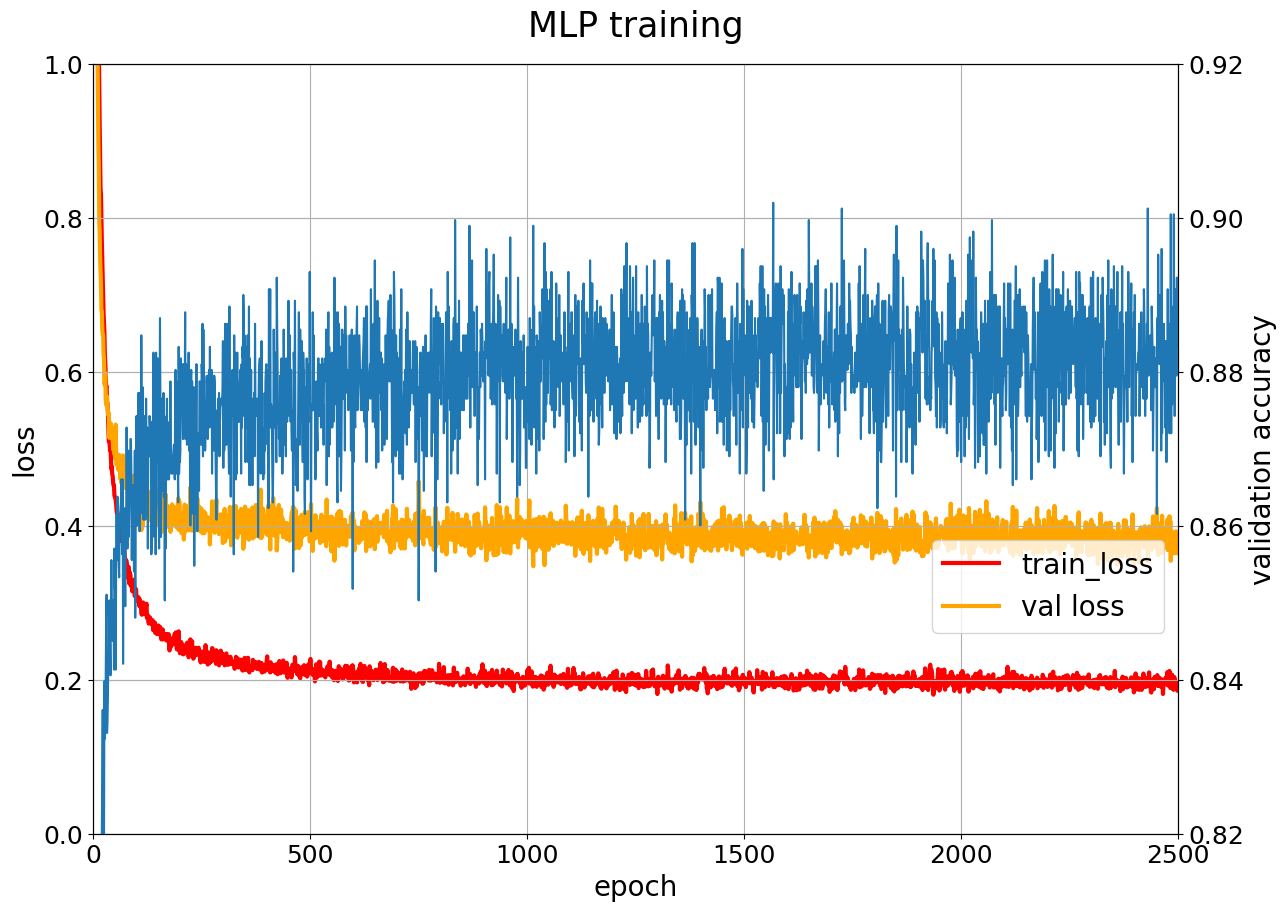

In [ ]:
# AdamW, l2 weight_decay = 0.2, lr = 0.001, batch_size = 128, with feature standardization
fig, ax1 = plt.subplots(figsize = (14, 10))
ax2 = ax1.twinx()
ax1.plot(np.arange(len(train_loss)), train_loss, 'r', linewidth = 3, label = 'train loss')
ax1.plot(np.arange(len(val_loss)), val_loss, 'orange', linewidth =3, label = 'val loss')
ax2.plot(np.arange(len(train_accuracy)), train_accuracy, 'r', linewidth = 3, label = 'train accuracy')
ax2.plot(np.arange(len(val_accuracy)), val_accuracy, 'orange', linewidth = 3, label = 'val accuracy')
ax1.set_xlim(0, len(train_loss))
ax1.set_ylim(0,1)
ax2.set_ylim(0.84,0.94)
ax1.grid()
ax2.grid()
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax1.set_xlabel('epoch', fontsize = 20)
ax1.set_ylabel('loss', fontsize = 20)
ax2.set_ylabel('accuracy', fontsize = 20)
fig.legend(loc="upper right", bbox_to_anchor=(1,0.4), bbox_transform=ax1.transAxes, fontsize = 20)
ax1.set_title('RNN training', fontsize = 25, y = 1.025)
